In [126]:
import dalex as dx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import sklearn.pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')

## Przygotowanie danych

In [2]:
x_train = dx.datasets.load_apartments()
y_train = x_train['m2_price']
x_train.drop('m2_price', axis=1, inplace=True)

x_test = dx.datasets.load_apartments_test()
y_test = x_test['m2_price']
x_test.drop('m2_price', axis= 1, inplace=True)

x_train.head()

,construction_year,surface,floor,no_rooms,district
1,1953,25,3,1,Srodmiescie
2,1992,143,9,5,Bielany
3,1937,56,1,2,Praga
4,1995,93,7,3,Ochota
5,1992,144,6,5,Mokotow


In [3]:
dist = x_test['district'].unique()

In [4]:
enc = ce.OneHotEncoder(cols=['district'], )
enc.fit(x_test)
x_test = enc.fit_transform(x_test)
x_train = enc.fit_transform(x_train)

In [5]:
x_test.columns.values[-10:] = dist
x_train.columns.values[-10:] = dist

In [6]:
def score_model(y, y_hat, func = (lambda x: x)):
    l = len(y)
    return round(sum((func(y)-func(y_hat))**2)/l, 2)

## Base line

Błąd średniokwadratowy ze średniej

In [7]:
score_model(y_test, y_test.mean())

810804.49

## Pierwszy model

Okazuje się gorszy od baseline

In [8]:
svm = SVR()
svm.fit(x_train, y_train)
y_hat = svm.predict(x_test)

In [9]:
score_model(y_test, y_hat)

826320.67

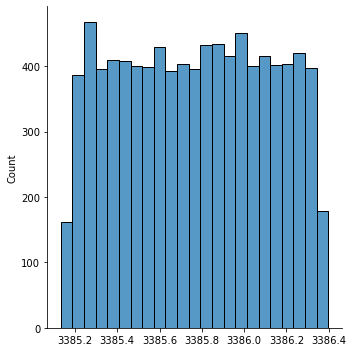

In [10]:
sns.displot(y_hat)

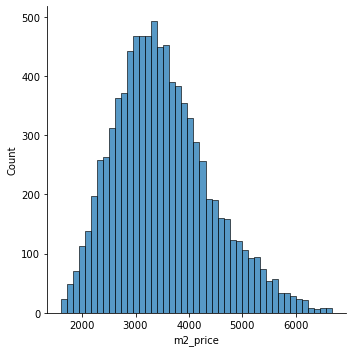

In [11]:
sns.displot(y_test)

## Skalowanie zmiennych

Skaluję zmienne przy pomocy MinMaxScaler

In [12]:
mm = MinMaxScaler()
mm_x_train = mm.fit_transform(x_train)
mm_x_test = mm.transform(x_test)

In [13]:
mm_x_train = pd.DataFrame(mm_x_train, columns=x_train.columns.values)
mm_x_test = pd.DataFrame(mm_x_test, columns=x_train.columns.values)

In [14]:
m = min(y_train)
r = max(y_train)-min(y_train)
mm_y_train = (y_train-m)/r
mm_y_test = (y_test-m)/r

## Model ze skalowaniem

Okazuje się, że przeskalowanie danych znacznie poprawia predykcyjność modelu, z zaznaczeniem, że przy mierzeniu błędu średniokwadratowego przeskalowuję spowrotem uzyskane pradykcję, aby były porównywalne.

In [17]:
svm2 = SVR()
svm.fit(mm_x_train, mm_y_train)
mm_y_hat = svm.predict(mm_x_test)

In [18]:
score_model(mm_y_test, mm_y_hat, lambda x: x*r+m)

360463.38

## Grid Search

Użyłem GridSearch aby sprawdzić czy jest możliwość polepszenia predykcyjności modelu. Okazuję się, że taki model ma nieznacznie większy błąd. A jedyny parametr jaki zmieniliśmy jest C (*cost*)

In [60]:
grid_search = {
    'C' : np.logspace(-4, 4, 10),
    'gamma' : ['scale', 'auto'],
    'degree' : range(1,5),
    'kernel' : ['linear', 'poly', 'rbf']
}

In [61]:
svr3 = SVR()

In [62]:
gs = GridSearchCV(svr3, grid_search, cv=10)

In [63]:
gs.fit(mm_x_train, mm_y_train)

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'degree': range(1, 5), 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

In [64]:
gs.best_params_

{'C': 0.3593813663804626, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [65]:
svr4 = SVR(C = 0.3593813663804626, degree= 1, gamma='scale', kernel='rbf')
svr4.fit(mm_x_train, mm_y_train)
gs_y_hat = svr4.predict(mm_x_test)

In [66]:
score_model(mm_y_test, gs_y_hat, lambda x: x*r+m)

360518.27

# Zbiór nr. 2

Zbiór pobrałem ze strony https://www.kaggle.com/iabhishekofficial/mobile-price-classification?select=train.csv.
Zawiera informację o parametrach telefonach komórkowych i ich przedziale cenowym. Aby zredukować problem z multi-label classification zmapuję przedziały cenowe odpowiednio:
- 0 -> 0
- 1 -> 0
- 2 -> 1
- 3 -> 1

In [135]:
x = pd.read_csv('train.csv')
y = x['price_range']
x.drop('price_range', axis = 1, inplace=True)
y = y.map(lambda x: x//2)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=1)

In [136]:
x_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1922,764,0,1.0,1,9,1,45,0.5,124,8,11,52,539,1341,19,1,12,1,0,0
1622,1057,1,2.7,0,3,1,41,0.1,97,4,10,397,891,2033,16,9,2,1,1,0
1921,569,1,2.5,1,0,0,41,0.3,124,1,1,388,605,2651,17,7,4,0,0,0
1499,1742,1,0.5,1,5,1,43,0.9,176,3,7,356,1407,1921,9,2,3,1,1,0
1082,1044,1,2.8,1,7,0,33,0.6,129,4,13,42,1262,1816,17,16,15,1,0,1


## Baseline

Ponieważ w naszych danych wszystkie przedziały cenowe mają taką samą ilość danych a przy podziale używamy parametru stratify to nasz baseline będzie wynosił 50%

<AxesSubplot:>

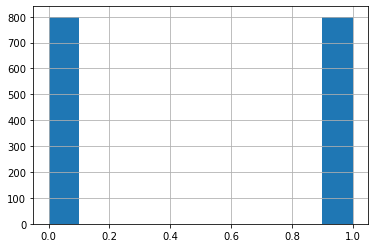

In [137]:
y_train.hist()

## Prosty model SVC

Nawet podstawowy model bardzo dobrze przewiduję ceny telefonów z 96,5 accuracy.

In [138]:
svc = SVC()
svc.fit(x_train, y_train)
svc.score(x_test, y_test)

0.965

In [144]:
cross_val_score(svc, x_train, y_train).mean()

0.985625

## SVC ze skalowaniem

Skaluję dane za pomocą MinMaxScaler. A poniweaż nasz target jest już przeskalowany to wystarczy użyć to na x_train, x_test.

Uzyskaliśmy bardzo ciekway wynik, ponieważ skalowanie danych pogorszyło wyniki przewidywań, aby to sprawdzić użyłem równeż walidacji krzyżowej której wyniki również były lepsze na danych nieprzeskalowanych.

In [139]:
mm = MinMaxScaler()
mm_x_train = mm.fit_transform(x_train)
mm_x_test = mm.transform(x_test)
mm_x_train = pd.DataFrame(mm_x_train, columns=x_train.columns.values)
mm_x_test = pd.DataFrame(mm_x_test, columns=x_train.columns.values)

In [140]:
svc2 = SVC()
svc2.fit(mm_x_train, y_train)
svc2.score(mm_x_test, y_test)

0.9325

In [149]:
cross_val_score(svc, mm_x_train, y_train).mean()

0.95375

## GridSearch na SVC

W tym przypaku dzięki GridSearch udało się poprawić wyniki SVC dla nieprzeskalowanych danych do 98,25% accuracy. Aby upewnić się, że skalowanie faktycznie daje gorsze wyniki jego brak, wykonałem gridsearch również dla danych przeskalowanych ale wyniki nadal były gorsze 96%.

In [183]:
grid_search2 = {
    'C' : np.logspace(-2, 2, 5),
    'gamma' : ['scale', 'auto'],
    'degree' : range(1,3),
    'kernel' : ['rbf']
}

In [184]:
svc3 = SVC()
gs_c = GridSearchCV(svc3, grid_search2)

In [185]:
gs_c.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'degree': range(1, 3), 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf']})

In [186]:
print('Accuracy dla modelu nie skalowanego: ' + str(gs_c.best_estimator_.score(x_test, y_test)))

Accuracy dla modelu nie skalowanego: 0.9825


In [187]:
svc3 = SVC()
gs_c2 = GridSearchCV(svc3, grid_search2)

In [188]:
gs_c2.fit(mm_x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'degree': range(1, 3), 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf']})

In [189]:
print('Accuracy dla modelu skalowanego: ' + str(gs_c2.best_estimator_.score(mm_x_test, y_test)))

Accuracy dla modelu skalowanego: 0.96


# Wnioski

Należy zauważyć, że wyniki modelowań różniły się w obu przypadkach. Na pierwszym zbiorze apartments z paczki *dalex* skalowanie danych znacznie poprawiło wyniki modelu ale już GridSearch minimalnie je pogorszył.  
W drugim przypadku skalowanie danych przyniosło znaczące pogorsznie wyników, a w takim wypadku GridSearch przyczynił się do ich małej poprawy. 